# Comparing soundings from NCEP Reanalysis and various models

We are going to plot the global, annual mean sounding (vertical temperature profile) from observations.

Read in the necessary NCEP reanalysis data from the online server.

The catalog is here: <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/catalog.html>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = nc.Dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc" )
level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]

Take global averages and time averages.

In [2]:
Tzon = np.mean(ncep_air.variables['air'],axis=(0,3))
Tglobal = np.sum( Tzon * np.cos(np.deg2rad(lat)), axis=1 ) / np.sum( np.cos(np.deg2rad(lat) ) )

Here is code to make a nicely labeled sounding plot.

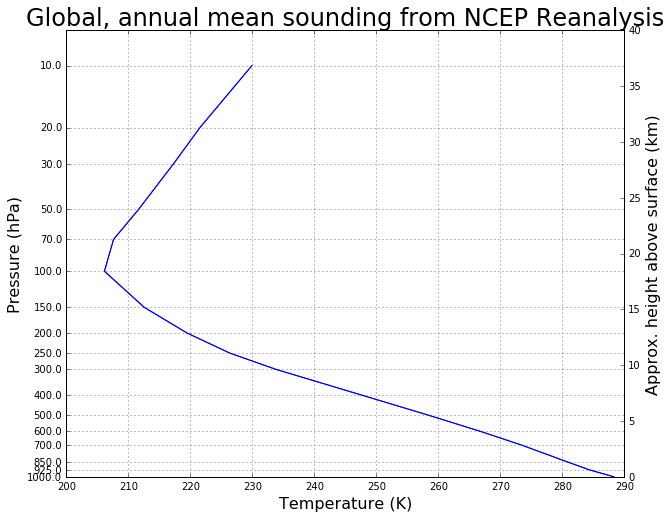

In [3]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000) )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax2 = ax.twinx()
ax2.plot( Tglobal + 273.15, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Now compute the Radiative Equilibrium solution for the grey-gas column model

In [4]:
from climlab import constants as const
from climlab.model import column

In [5]:
col = column.GreyRadiationModel()
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [6]:
col.subprocess['LW'].diagnostics

{'absorbed': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 'absorbed_total': Field([ 0.]),
 'emission': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 'emission_sfc': Field([ 0.]),
 'flux_from_sfc': Field([ 0.]),
 'flux_reflected_up': 0.0,
 'flux_to_sfc': Field([ 0.]),
 'flux_to_space': Field([ 0.])}

In [7]:
col.subprocess['LW'].compute()

In [8]:
col.integrate_years(1)

print "Surface temperature is " + str(col.state['Ts']) + " K."
print "Net energy in to the column is " + str(col.diagnostics['ASR'] - col.diagnostics['OLR']) + " W / m2."

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.999336878378 years.
Surface temperature is [ 287.84577808] K.
Net energy in to the column is [ 0.0016903] W / m2.


### Plot the radiative equilibrium temperature on the same plot with NCEP reanalysis

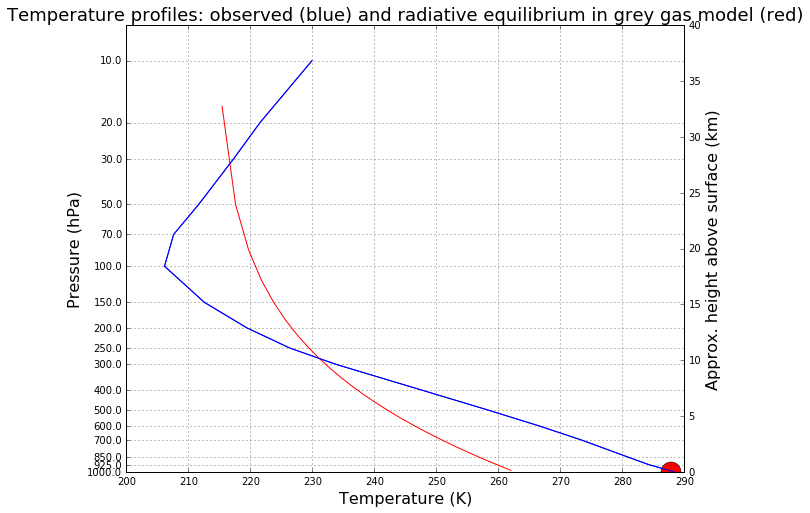

In [9]:
pcol = col.lev

fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.state['Tatm'], np.log( pcol/const.ps ), 'r-' )
ax.plot( col.state['Ts'], 0, 'ro', markersize=20 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue) and radiative equilibrium in grey gas model (red)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Now use convective adjustment to compute a Radiative-Convective Equilibrium temperature profile

In [10]:
dalr_col = column.RadiativeConvectiveModel(adj_lapse_rate='DALR')
print dalr_col

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [11]:
dalr_col.integrate_years(2.)

print "After " + str(dalr_col.time['days_elapsed']) + " days of integration:"
print "Surface temperature is " + str(dalr_col.state['Ts']) + " K."
print "Net energy in to the column is " + str(dalr_col.diagnostics['ASR'] - dalr_col.diagnostics['OLR']) + " W / m2."

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.
After 730.0 days of integration:
Surface temperature is [ 283.040058] K.
Net energy in to the column is [  1.12035451e-06] W / m2.


In [12]:
dalr_col.param

{'Q': 341.3,
 'abs_coeff': 0.0001229,
 'adj_lapse_rate': 'DALR',
 'albedo_sfc': 0.299,
 'timestep': 86400.0,
 'water_depth': 1.0}

Now plot this "Radiative-Convective Equilibrium" on the same graph:

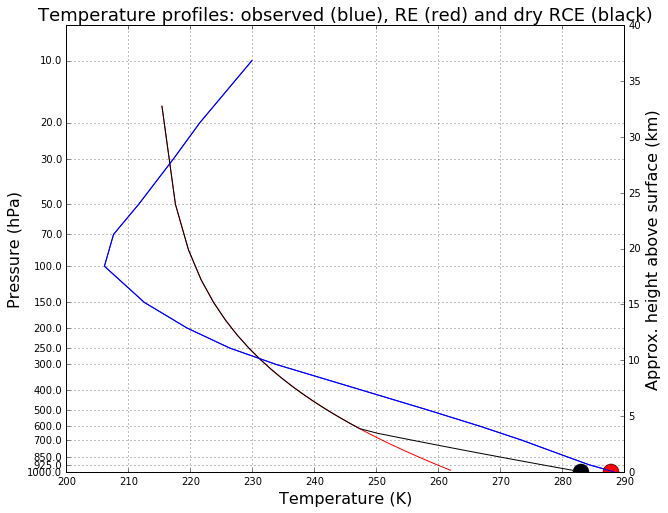

In [13]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.state['Tatm'], np.log( pcol/const.ps ), 'r-' )
ax.plot( col.state['Ts'], 0, 'ro', markersize=16 )
ax.plot( dalr_col.state['Tatm'], np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.state['Ts'], 0, 'ko', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue), RE (red) and dry RCE (black)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

The convective adjustment gets rid of the unphysical temperature difference between the surface and the overlying air.

But now the surface is colder! Convection acts to move heat upward, away from the surface.

Also, we note that the observed lapse rate (blue) is always shallower than $\Gamma_d$ (temperatures decrease more slowly with height).

## "Moist" Convective Adjustment

To approximately account for the effects of latent heat release in rising air parcels, we can just adjust to a lapse rate that is a little shallow than $\Gamma_d$.

We will choose 6 K / km, which gets close to the observed mean lapse rate.

We will also re-tune the longwave absorptivity of the column to get a realistic surface temperature of 288 K:


In [14]:
rce_col = column.RadiativeConvectiveModel(adj_lapse_rate=6, abs_coeff=1.7E-4)
print rce_col

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [15]:
rce_col.integrate_years(2.)

print "After " + str(rce_col.time['days_elapsed']) + " days of integration:"
print "Surface temperature is " + str(rce_col.state['Ts']) + " K."
print "Net energy in to the column is " + str(rce_col.diagnostics['ASR'] - rce_col.diagnostics['OLR']) + " W / m2."

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.
After 730.0 days of integration:
Surface temperature is [ 287.9049635] K.
Net energy in to the column is [  2.19746957e-06] W / m2.


Now add this new temperature profile to the graph:

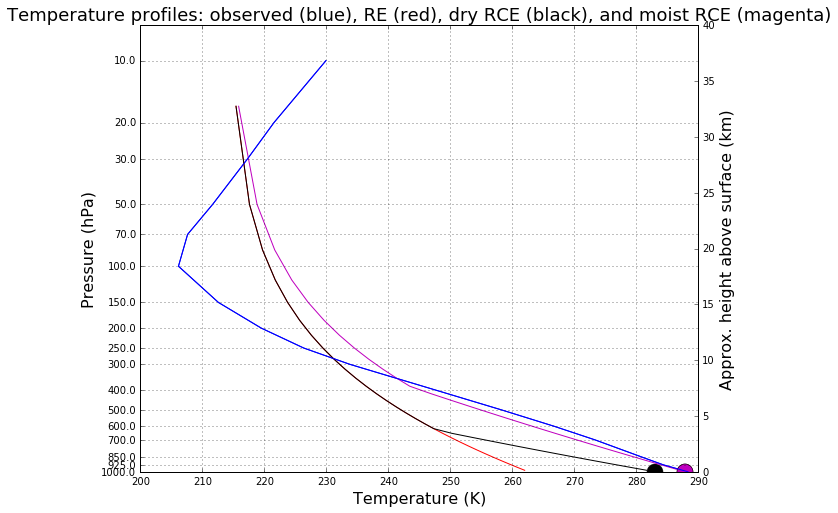

In [16]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.state['Tatm'], np.log( pcol/const.ps ), 'r-' )
ax.plot( col.state['Ts'], 0, 'ro', markersize=16 )
ax.plot( dalr_col.state['Tatm'], np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.state['Ts'], 0, 'ko', markersize=16 )
ax.plot( rce_col.state['Tatm'], np.log( pcol / const.ps ), 'm-' )
ax.plot( rce_col.state['Ts'], 0, 'mo', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue), RE (red), dry RCE (black), and moist RCE (magenta)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Adding stratospheric ozone

Our model has no equivalent of the stratosphere, where temperature increases with height. That's because our model has been completely transparent to shortwave radiation up until now.

We can load the observed ozone climatology from the input files for the CESM model:

In [17]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

In [18]:
print ozone.variables['O3']

<type 'netCDF4._netCDF4.Variable'>
float32 O3(time, lev, lat, lon)
    units: mol/mol
    long_name: O3 concentration
    cell_method: time: mean
unlimited dimensions: time
current shape = (12, 26, 96, 144)
filling off



In [19]:
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

The pressure levels in this dataset are:

In [20]:
print lev

[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]


Take the global average of the ozone climatology, and plot it as a function of pressure (or height)

In [21]:
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )
O3_global = np.sum( O3_zon * np.cos(np.deg2rad(lat)), axis=1 ) / np.sum( np.cos(np.deg2rad(lat) ) )

In [22]:
O3_global.shape

(26,)

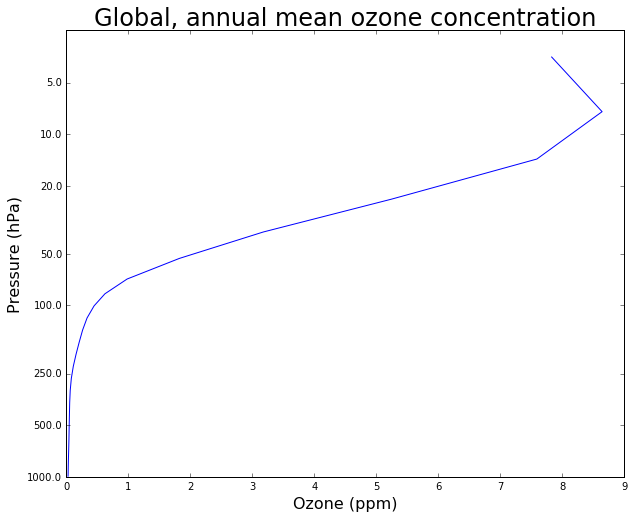

In [23]:
ax = plt.figure(figsize=(10,8)).add_subplot(111)
ax.plot( O3_global * 1.E6, np.log(lev/const.ps) )
ax.invert_yaxis()
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
yticks = np.array([1000., 500., 250., 100., 50., 20., 10., 5.])
ax.set_yticks( np.log(yticks/1000.) )
ax.set_yticklabels( yticks )
ax.set_title('Global, annual mean ozone concentration', fontsize = 24);

This shows that most of the ozone is indeed in the stratosphere, and peaks near the top of the stratosphere.

Now create a new column model object **on the same pressure levels as the ozone data**.  We are also going set an adjusted lapse rate of 6 K / km, and tune the longwave absorption 

In [24]:
oz_col = column.RadiativeConvectiveModel(lev = lev, abs_coeff=1.82E-4, adj_lapse_rate=6, albedo=0.315)

Now we will do something new: let the column absorb some shortwave radiation. We will assume that the shortwave absorptivity is proportional to the ozone concentration we plotted above.  We need to weight the absorptivity by the pressure (mass) of each layer.

In [25]:
ozonefactor = 75
dp = oz_col.Tatm.domain.axes['lev'].delta
sw_abs = O3_global * dp * ozonefactor
oz_col.subprocess.SW.absorptivity = sw_abs
oz_col.compute()
oz_col.compute()
print oz_col.SW_absorbed_atm

[ 1.40571621  1.47671285  2.0568557   1.99236562  1.50916588  0.97239285
  0.51429089  0.30750442  0.23797743  0.20913837  0.19309134  0.17981756
  0.1597929   0.13452308  0.11343944  0.10393805  0.10574109  0.11442201
  0.12396838  0.12743553  0.11515129  0.09328389  0.07161233  0.04975714
  0.02927232  0.01641659]


Now run it out to Radiative-Convective Equilibrium, and plot

In [26]:
oz_col.integrate_years(2.)

print "After " + str(oz_col.time['days_elapsed']) + " days of integration:"
print "Surface temperature is " + str(oz_col.state['Ts']) + " K."
print "Net energy in to the column is " + str(oz_col.ASR - oz_col.OLR) + " W / m2."

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.
After 730.0 days of integration:
Surface temperature is [ 289.52273604] K.
Net energy in to the column is [  7.02541598e-07] W / m2.


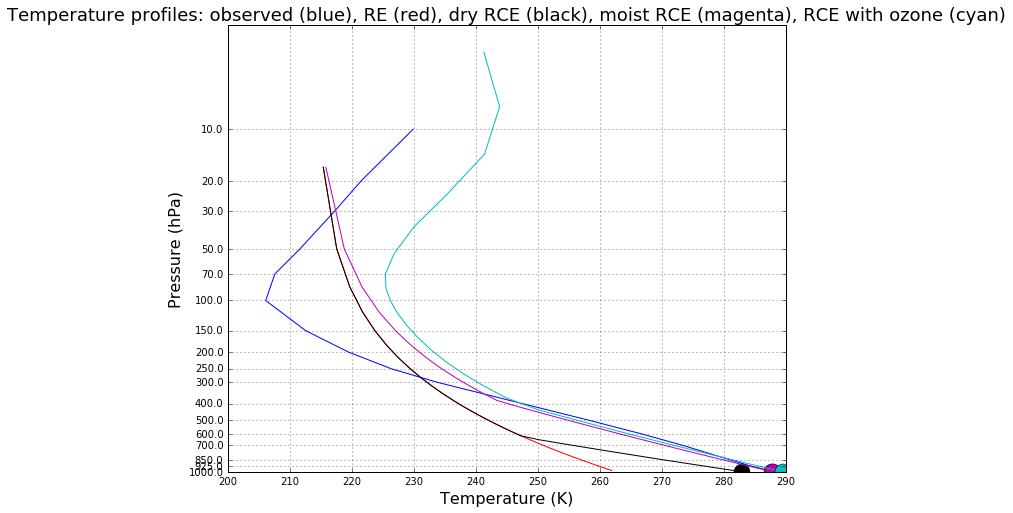

In [27]:
pozcol = oz_col.lev

fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/1000), 'b-', col.state['Tatm'], np.log( pcol/const.ps ), 'r-' )
ax.plot( col.state['Ts'], 0, 'ro', markersize=16 )
ax.plot( dalr_col.state['Tatm'], np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.state['Ts'], 0, 'ko', markersize=16 )
ax.plot( rce_col.state['Tatm'], np.log( pcol / const.ps ), 'm-' )
ax.plot( rce_col.state['Ts'], 0, 'mo', markersize=16 )
ax.plot( oz_col.state['Tatm'], np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.state['Ts'], 0, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue), RE (red), dry RCE (black), moist RCE (magenta), RCE with ozone (cyan)', fontsize = 18)
ax.grid()

And we finally have something that looks looks like the tropopause, with temperature increasing above at about the correct rate. Though the tropopause temperature is off by 15 degrees or so.

## Greenhouse warming in the RCE model with ozone

In [28]:
from climlab.process.process import process_like
oz_col2 = process_like( oz_col )

In [29]:
oz_col2.subprocess['LW'].absorptivity *= 1.2 

In [30]:
oz_col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 3.99734751351 years.


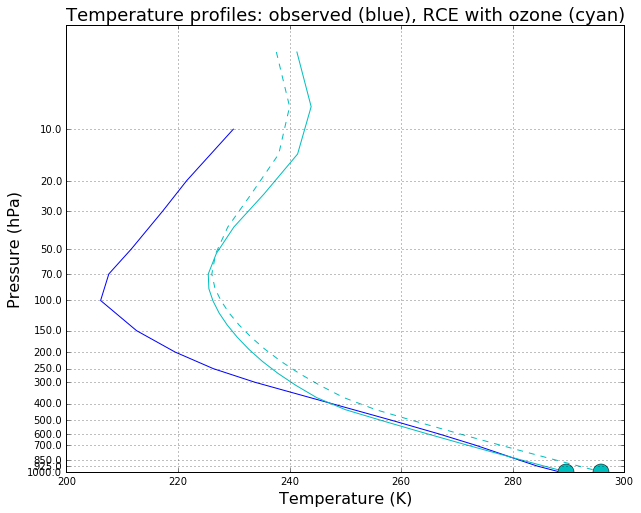

In [31]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/const.ps), 'b-' )
ax.plot( oz_col.state['Tatm'], np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.state['Ts'], 0, 'co', markersize=16 )
ax.plot( oz_col2.state['Tatm'], np.log( pozcol / const.ps ), 'c--' )
ax.plot( oz_col2.state['Ts'], 0, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/const.ps) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue), RCE with ozone (cyan)', fontsize = 18)
ax.grid()

And we find that the troposphere warms, while the stratosphere cools!

### Vertical structure of greenhouse warming in CESM model

In [32]:
atmstr = ".cam.h0.clim.nc"
cesm_ctrl = nc.Dataset( datapath + 'som_control/som_control' + atmstr + endstr )
cesm_2xCO2 = nc.Dataset( datapath + 'som_2xCO2/som_2xCO2' + atmstr + endstr )

In [33]:
T_cesm_ctrl = cesm_ctrl.variables['T'][:]
T_cesm_2xCO2 = cesm_2xCO2.variables['T'][:]
print T_cesm_ctrl.shape

(12, 26, 96, 144)


In [34]:
T_cesm_ctrl_zon = np.mean( T_cesm_ctrl, axis=(0,3) )
T_cesm_2xCO2_zon = np.mean( T_cesm_2xCO2, axis=(0,3) )

In [35]:
T_cesm_2xCO2_glob = np.empty_like( lev )
T_cesm_ctrl_glob = np.empty_like( lev )
for n in range( lev.size ):
    T_cesm_ctrl_glob[n] = np.sum( T_cesm_ctrl_zon[n,:] * np.cos( np.deg2rad( lat ) ) ) / np.sum( np.cos( np.deg2rad( lat ) ) )
    T_cesm_2xCO2_glob[n] = np.sum( T_cesm_2xCO2_zon[n,:] * np.cos( np.deg2rad( lat ) ) ) / np.sum( np.cos( np.deg2rad( lat ) ) )

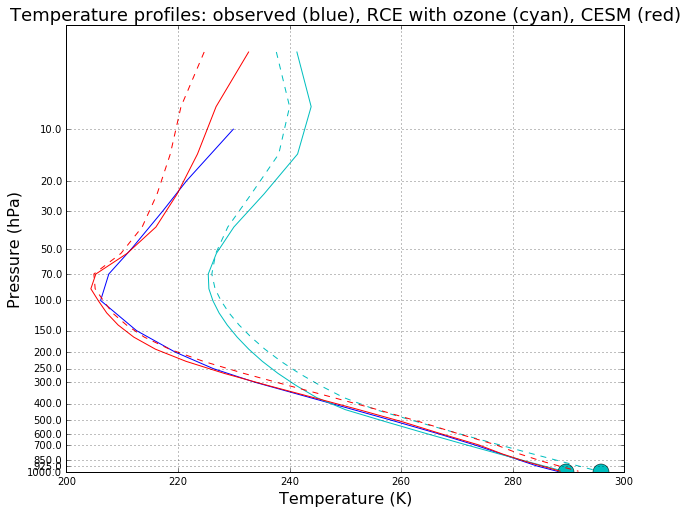

In [36]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/const.ps), 'b-' )
ax.plot( oz_col.state['Tatm'], np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.state['Ts'], 0, 'co', markersize=16 )
ax.plot( oz_col2.state['Tatm'], np.log( pozcol / const.ps ), 'c--' )
ax.plot( oz_col2.state['Ts'], 0, 'co', markersize=16 )
ax.plot( T_cesm_ctrl_glob, np.log( lev/const.ps ), 'r-' )
ax.plot( T_cesm_2xCO2_glob, np.log( lev/const.ps ), 'r--' )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/const.ps) )
ax.set_yticklabels( level )
ax.set_title('Temperature profiles: observed (blue), RCE with ozone (cyan), CESM (red)', fontsize = 18)
ax.grid()

And we find that CESM has the same tendency for increased CO2: warmer troposphere, colder stratosphere.